In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/CS 410/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Start
Importing necessary libraries:

In [1]:
import torch
import pandas as pd
import numpy as np
import pickle
import re,string,nltk
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 17.7 MB/s 
     |████████████████████████████████| 7.6 MB 59.5 MB/s 
     |████████████████████████████████| 182 kB 80.0 MB/s 


In [4]:
import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [5]:
headlines = []
targets = []

Loading the dataset:

In [8]:
df = pd.read_json("Sarcasm_Headlines_Dataset.json",lines=True)

In [9]:
df[0:5]

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [10]:
df['headline'][1]

"the 'roseanne' revival catches up to our thorny political mood, for better and worse"

# Pre-Processing
We define two preprocessing functions:

`clean_text()` to remove symbols, punctations, numbers, and convert all text to lower case

`preprocess_text()` to expand abbreviations

In [11]:
def clean_text(df,field):
    df[field] = df[field].str.replace(r"@","at")
    df[field] = df[field].str.replace("#[A-Za-z0-9_]+", ' ')
    df[field] = df[field].str.replace(r"[^A-Za-z(),!?@\'\"_\n]"," ")
    df[field] = df[field].str.lower()
    return df 
    
def preprocess_text(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would",text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = re.sub(r'[^\x00-\x7f]','',text)
    return text

In [12]:
df['headline'] = df['headline'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

In [13]:
df['headline'][1]

'the roseanne revival catches up to our thorny political mood for better and worse'

### Data Visualization

[visualization-reference][visr]

[visr]: https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy "Data Visualization Ref"

Check the balance of sarcastic and non-sarcastic headlines in the data set

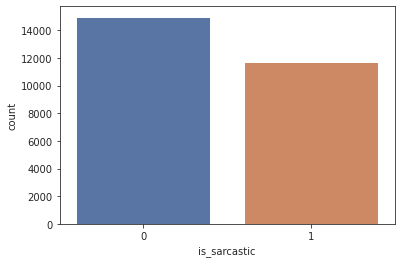

In [14]:
sns.set_style("ticks")
sns.countplot(data=df, x="is_sarcastic", palette = 'deep')

Number of characters in the headline

Text(0.5, 0, 'Number of characters')

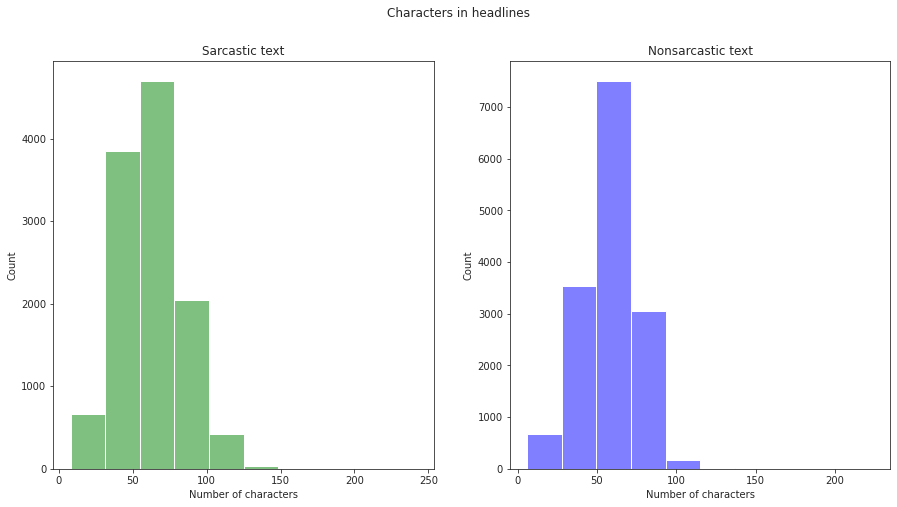

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,7.5))
fig.suptitle('Characters in headlines')

text_len=df[df['is_sarcastic']==1]['headline'].str.len()
sns.histplot(text_len, ax=ax1, color='green', bins=10, alpha=0.5)
ax1.set_title('Sarcastic text')
ax1.set_xlabel('Number of characters')


text_len=df[df['is_sarcastic']==0]['headline'].str.len()
sns.histplot(text_len, ax=ax2, color='blue', bins=10, alpha=0.5)
ax2.set_title('Nonsarcastic text')
ax2.set_xlabel('Number of characters')

Number of words in each headline

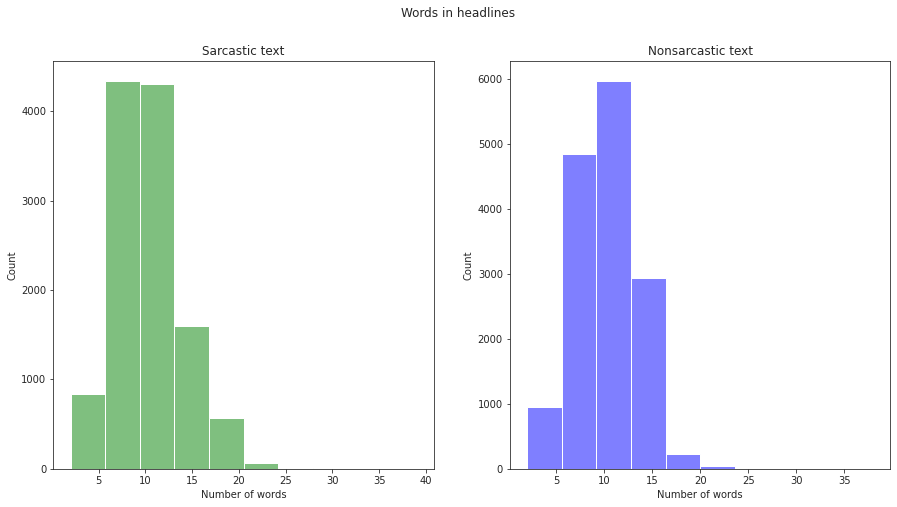

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,7.5))
fig.suptitle('Words in headlines')

text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
sns.histplot(text_len, ax=ax1, color='green', bins=10, alpha=0.5)
ax1.set_title('Sarcastic text')
ax1.set_xlabel('Number of words')


text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
sns.histplot(text_len, ax=ax2, color='blue', bins=10, alpha=0.5)
ax2.set_title('Nonsarcastic text')
ax2.set_xlabel('Number of words')

plt.show()

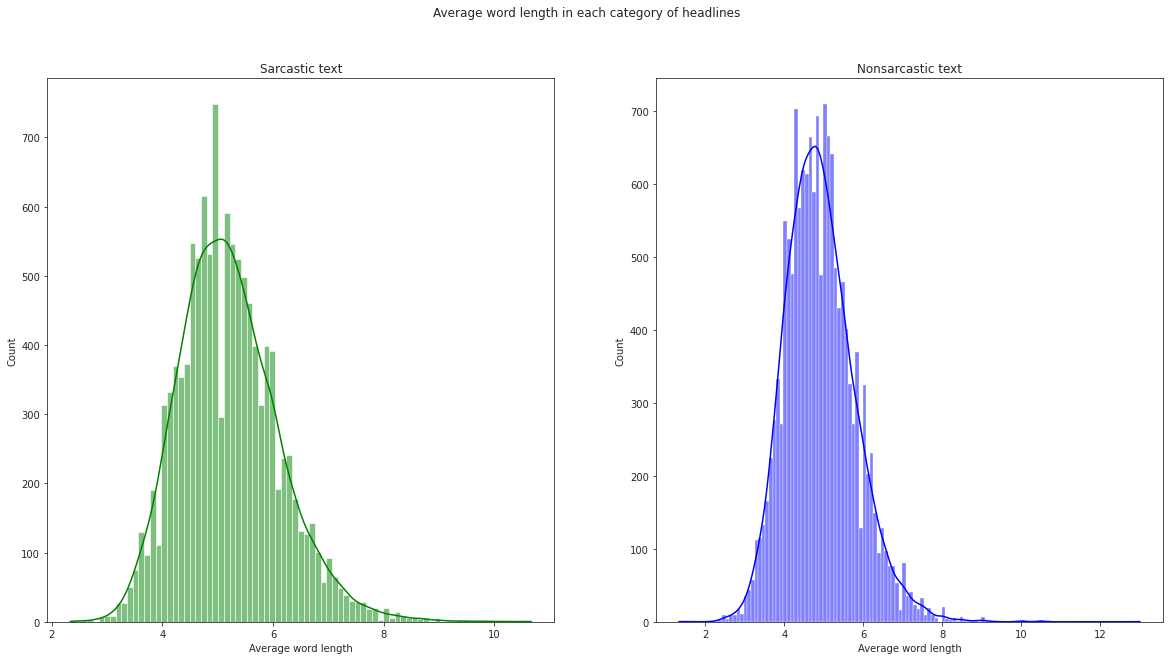

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
fig.suptitle('Average word length in each category of headlines')


word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(data=word.map(lambda x: np.mean(x)), ax=ax1, color='green', kde=True)
ax1.set_title('Sarcastic text')
ax1.set_xlabel('Average word length')


word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(data=word.map(lambda x: np.mean(x)), ax=ax2, color='blue', kde=True)
ax2.set_title('Nonsarcastic text')
ax2.set_xlabel('Average word length')

plt.show()

Wordcloud for sarcastic headlines

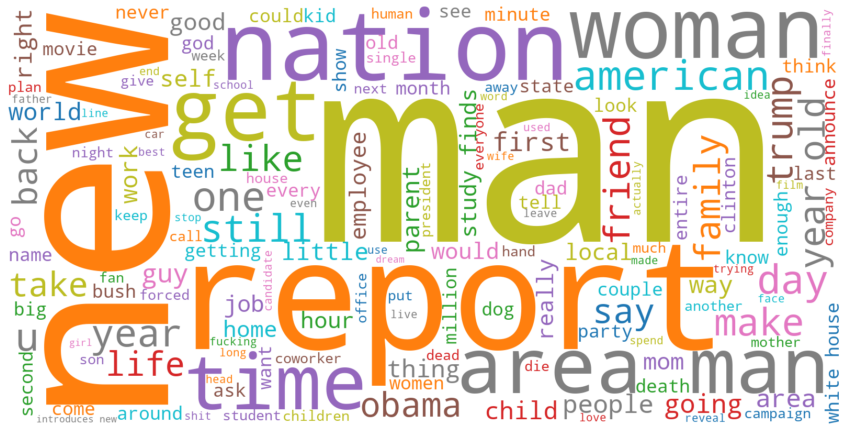

In [18]:
stopwords_e = set(stopwords.words('english'))

plt.figure(figsize = (15, 15))
wc = WordCloud(max_words = 150,
               width = 1600, 
               height = 800,
               max_font_size=500,
               colormap='tab10',
               collocations=True,
               stopwords=stopwords_e,
               background_color ='white').generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Wordcloud for nonsarcastic headlines

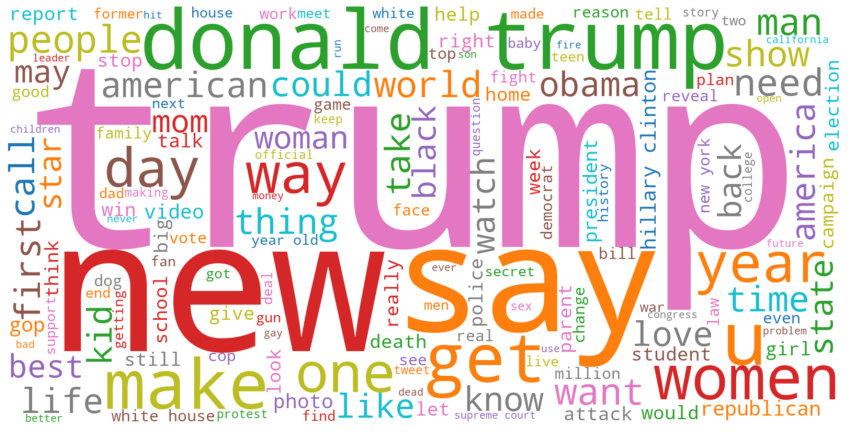

In [19]:
plt.figure(figsize = (15, 15))
wc = WordCloud(max_words = 150,
               width = 1600, 
               height = 800,
               max_font_size=500,
               colormap='tab10',
               collocations=True,
               stopwords=stopwords_e,
               background_color ='white').generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Training the Model

In [20]:
features = df['headline']
targets = df['is_sarcastic']

In [21]:
len(features)

26709

In [22]:
features = features.to_list()
targets = targets.to_list()

In [23]:
trainfeatures = features[:20000]
testfeatures = features[20000:]
traintargets = targets[:20000]
testtargets = targets[20000:]

In [24]:
counts = np.bincount(traintargets)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(traintargets)
    )
)

weight_for_0 = counts[0]/counts[0]
weight_for_1 = counts[0]/counts[1]

Number of positive samples in training data: 8794 (43.97% of total)


In [25]:
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 1.0, 1: 1.2742779167614282}

We built a DistilBERT tokenizer and a DistilBERT model. DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base.

More information about the model can be found at [Distillbert](https://huggingface.co/docs/transformers/v4.25.1/en/model_doc/distilbert).

In [26]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

In [27]:
trainset = tokenizer(trainfeatures, padding="max_length", truncation=True)

In [28]:
testset = tokenizer(testfeatures, padding=True, truncation=True)

In [ ]:
class twitterDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item
  def __len__(self):
    return len(self.labels)
traindataset = twitterDataset(trainset, traintargets)
testdataset = twitterDataset(testset, testtargets)

In [ ]:
traindataset.__getitem__(1)

{'input_ids': tensor([  101,  1996,  3123, 20147,  6308, 11269,  2039,  2000,  2256, 16337,
          2100,  2576,  6888,  2005,  2488,  1998,  4788,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    weights = torch.tensor([1.0, 1.2742779167614282]).to(device)
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = torch.nn.CrossEntropyLoss(weight=weights)
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [ ]:
trainingargs = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10)
trainer = CustomTrainer(
    model=model,
    args=trainingargs,
    train_dataset=traindataset,
    eval_dataset=testdataset)
torch.cuda.empty_cache()
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1250
  Number of trainable parameters = 66955010


Step,Training Loss
10,0.690900
20,0.688200
30,0.675200
40,0.647000
50,0.567400
60,0.499400
70,0.420800
80,0.415800
90,0.376500
100,0.402600


Step,Training Loss
10,0.690900
20,0.688200
30,0.675200
40,0.647000
50,0.567400
60,0.499400
70,0.420800
80,0.415800
90,0.376500
100,0.402600


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1250, training_loss=0.21567855248451234, metrics={'train_runtime': 1861.5017, 'train_samples_per_second': 21.488, 'train_steps_per_second': 0.672, 'total_flos': 5298695946240000.0, 'train_loss': 0.21567855248451234, 'epoch': 2.0})

In [ ]:
torch.save(model, '/content/gdrive/My Drive/CS 410/model_file_A.pt')
model = torch.load('/content/gdrive/My Drive/CS 410/model_file_A.pt')
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
def checkresult(model, inputid, attentionmask):
  inputid = torch.tensor(inputid).to(device)
  attentionmask = torch.tensor(attentionmask).to(device)
  with torch.no_grad():
    output = model(inputid.unsqueeze(0), attentionmask.unsqueeze(0))
  y = np.argmax(output[0].to('cpu').numpy())
  return y

In [ ]:
preds = []
for i,j in zip(testset['input_ids'], testset['attention_mask']):
  pred = checkresult(model,i,j)
  preds.append(pred)

In [ ]:
print(classification_report(testtargets, preds, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      3779
           1       0.92      0.89      0.90      2930

    accuracy                           0.92      6709
   macro avg       0.92      0.91      0.92      6709
weighted avg       0.92      0.92      0.92      6709

